In [ ]:
!pip install -q transformers datasets torch seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

In [ ]:
raw_df = pd.read_csv("/content/merged.csv")
print("Shape of data:", raw_df.shape)
print("Columns:", raw_df.columns.tolist())
print("Label distribution:\n", raw_df["label"].value_counts())


Shape of data: (1178, 59)
Columns: ['Unnamed: 0', 'net_acc_mean', 'net_acc_std', 'net_acc_min', 'net_acc_max', 'ACC_x_mean', 'ACC_x_std', 'ACC_x_min', 'ACC_x_max', 'ACC_y_mean', 'ACC_y_std', 'ACC_y_min', 'ACC_y_max', 'ACC_z_mean', 'ACC_z_std', 'ACC_z_min', 'ACC_z_max', 'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max', 'EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max', 'EDA_phasic_mean', 'EDA_phasic_std', 'EDA_phasic_min', 'EDA_phasic_max', 'EDA_smna_mean', 'EDA_smna_std', 'EDA_smna_min', 'EDA_smna_max', 'EDA_tonic_mean', 'EDA_tonic_std', 'EDA_tonic_min', 'EDA_tonic_max', 'Resp_mean', 'Resp_std', 'Resp_min', 'Resp_max', 'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max', 'BVP_peak_freq', 'TEMP_slope', 'subject', 'label', 'age', 'height', 'weight', 'gender_ female', 'gender_ male', 'coffee_today_YES', 'sport_today_YES', 'smoker_NO', 'smoker_YES', 'feel_ill_today_YES']
Label distribution:
 label
1    628
2    355
0    195
Name: count, dtype: int64


##Basic Preprocessing##

In [ ]:
possible_drop_cols = ['subject', 'age', 'gender', 'height', 'weight', 'coffee_today_YES', 'smoker_YES']
drop_cols = [col for col in possible_drop_cols if col in raw_df.columns]
df = raw_df.drop(columns=drop_cols)
df = df.interpolate().dropna()

In [ ]:
if df['label'].dtype == object:
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

In [ ]:
# Step 5: Normalize numeric features (exclude timestamp & label)
features = df.drop(columns=['label'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)
df_scaled = pd.DataFrame(X_scaled, columns=features.columns)
df_scaled['label'] = df['label'].values

In [ ]:
# Step 6: Segment Data into Sliding Windows
WINDOW_SIZE = 60
STEP_SIZE = 30
segments = []
labels_windows = []

In [ ]:
for start in range(0, len(df_scaled) - WINDOW_SIZE, STEP_SIZE):
    end = start + WINDOW_SIZE
    window = df_scaled.iloc[start:end]
    if len(window) == WINDOW_SIZE:
        segment_text = ' '.join(window.drop(columns=['label']).astype(str).values.flatten())
        segments.append(segment_text)
        label = window['label'].mode()[0]
        labels_windows.append(label)

In [ ]:

# Step 7: Load Transformer Model (mock PhysioBERT with 'bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Step 8: Tokenize & Embed Sequences
embedding_list = []
with torch.no_grad():
    for seg in tqdm(segments, desc="Extracting Embeddings"):
        inputs = tokenizer(seg, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embedding_list.append(embedding)


Extracting Embeddings: 100%|██████████| 38/38 [00:44<00:00,  1.16s/it]


In [ ]:
X_embeddings = np.array(embedding_list)
y = np.array(labels_windows)

In [ ]:
# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Step 10: Train Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Step 11: Evaluate
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


Classification Report:
               precision    recall  f1-score   support

           1       0.88      1.00      0.93         7
           2       0.00      0.00      0.00         1

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8

Accuracy: 0.875
Precision: 0.765625
Recall: 0.875
F1 Score: 0.8166666666666667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


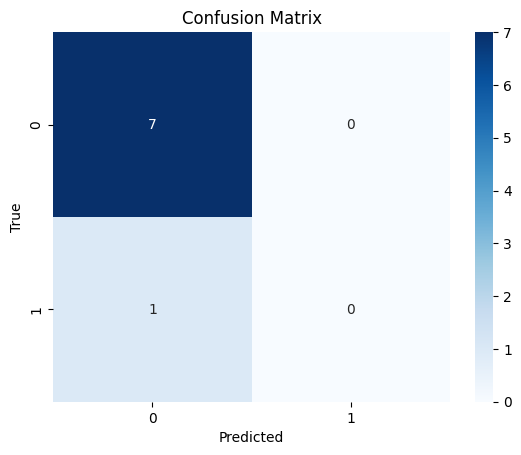

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Step 12: Save Segment Strings for Visualization
segments_df = pd.DataFrame({
    "window_text": segments,
    "label": labels_windows
})
segments_df.to_csv("physiobert_input_strings.csv", index=False)
print("Saved segment strings to physiobert_input_strings.csv")

# Optionally, download the file in Colab
from google.colab import files
files.download("physiobert_input_strings.csv")


Saved segment strings to physiobert_input_strings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Optimize Your Model for Better Performance##

**Instead of RandomForestClassifier, you can use a gradient boosting model like XGBoost or LightGBM, which often performs better.**


In [ ]:
import xgboost as xgb

# Copy original train-test splits into new variables
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()

# Map labels to start from 0 without affecting original
label_map = {label: idx for idx, label in enumerate(sorted(np.unique(y_train_xgb)))}
y_train_xgb = np.array([label_map[val] for val in y_train_xgb])
y_test_xgb = np.array([label_map[val] for val in y_test_xgb])

# Initialize and train XGBoost
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_clf.fit(X_train_xgb, y_train_xgb)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.00      0.00      0.00         1

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8

Accuracy: 0.875
Precision: 0.765625
Recall: 0.875
F1 Score: 0.8166666666666667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


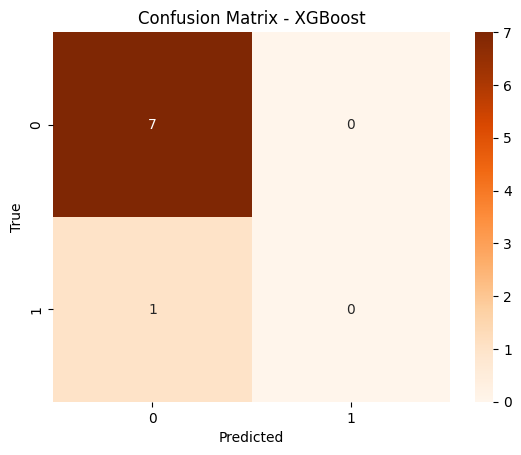

In [ ]:
y_pred_xgb = xgb_clf.predict(X_test_xgb)

print("\nClassification Report (XGBoost):\n", classification_report(y_test_xgb, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb))
print("Precision:", precision_score(y_test_xgb, y_pred_xgb, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test_xgb, y_pred_xgb, average='weighted'))
print("F1 Score:", f1_score(y_test_xgb, y_pred_xgb, average='weighted'))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost")
plt.show()


**Apply SMOTE to Balance Classes**
Adjust k_neighbors Based on Minority Class Size and ---
Apply SMOTE with Dynamic k_neighbors


In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check class distribution
class_counts = Counter(y_train_xgb)
print("Class distribution before SMOTE:", class_counts)

# Get smallest class size
min_class_samples = min(class_counts.values())

# Set k_neighbors < min_class_samples
k_val = min(min_class_samples - 1, 5)

# Apply SMOTE with adjusted k
sm = SMOTE(random_state=42, k_neighbors=k_val)
X_train_xgb_sm, y_train_xgb_sm = sm.fit_resample(X_train_xgb, y_train_xgb)

print("Class distribution after SMOTE:", Counter(y_train_xgb_sm))


Class distribution before SMOTE: Counter({0: 26, 1: 4})
Class distribution after SMOTE: Counter({0: 26, 1: 26})


Train XGBoost on SMOTE Data

In [ ]:
xgb_clf_sm = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_clf_sm.fit(X_train_xgb_sm, y_train_xgb_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report (XGBoost + SMOTE):
               precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.00      0.00      0.00         1

    accuracy                           0.88         8
   macro avg       0.44      0.50      0.47         8
weighted avg       0.77      0.88      0.82         8

Accuracy: 0.875
Precision: 0.765625
Recall: 0.875
F1 Score: 0.8166666666666667


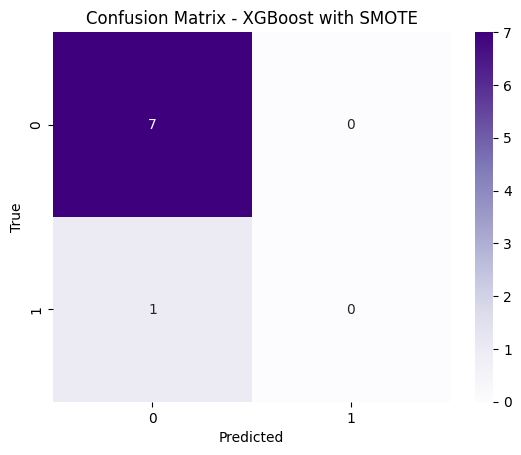

In [ ]:
y_pred_xgb_sm = xgb_clf_sm.predict(X_test_xgb)

print("\nClassification Report (XGBoost + SMOTE):\n", classification_report(y_test_xgb, y_pred_xgb_sm))
print("Accuracy:", accuracy_score(y_test_xgb, y_pred_xgb_sm))
print("Precision:", precision_score(y_test_xgb, y_pred_xgb_sm, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test_xgb, y_pred_xgb_sm, average='weighted'))
print("F1 Score:", f1_score(y_test_xgb, y_pred_xgb_sm, average='weighted'))

# Confusion Matrix
cm_xgb_sm = confusion_matrix(y_test_xgb, y_pred_xgb_sm)
sns.heatmap(cm_xgb_sm, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost with SMOTE")
plt.show()


##:Branch off and Try TimeGPT Embeddings##
Let’s say you keep your BERT-based X_embeddings as X_bert_embed.

You can now add a TimeGPT-based embedding path:

##Optionally: Use an existing time-series transformer from tsai:##

In [2]:
!pip install tsai


**Recreate df_scaled from Uploaded Data**

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load your dataset (make sure merged.csv is uploaded again)
raw_df = pd.read_csv("merged.csv")

# Drop irrelevant columns if they exist
possible_drop_cols = ['subject', 'age', 'gender', 'height', 'weight', 'coffee_today_YES', 'smoker_YES']
drop_cols = [col for col in possible_drop_cols if col in raw_df.columns]
df_temp = raw_df.drop(columns=drop_cols)

# Fill missing values
df_temp = df_temp.interpolate().dropna()

# Encode label if it's not numeric
if df_temp['label'].dtype == object:
    le = LabelEncoder()
    df_temp['label'] = le.fit_transform(df_temp['label'])

# Scale all features except label
features = df_temp.drop(columns=['label'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Final scaled dataframe
df_scaled = pd.DataFrame(X_scaled, columns=features.columns)
df_scaled['label'] = df_temp['label'].values


In [6]:
X_array = df_scaled.drop(columns=['label']).values
y_array = df_scaled['label'].values


In [7]:
print(df_scaled.head())
print(df_scaled['label'].value_counts())


   Unnamed: 0  net_acc_mean  net_acc_std  net_acc_min  net_acc_max  \
0   -1.730581      0.037111     1.690034    -1.299795     2.343844   
1   -1.727640     -0.797006     3.284458    -1.299795     1.460136   
2   -1.724700     -0.917309     1.985042    -1.093426     0.499585   
3   -1.721759      0.510472    -0.135361    -0.267948    -0.268857   
4   -1.718818     -0.074758     0.187103    -0.267948    -0.384123   

   ACC_x_mean  ACC_x_std  ACC_x_min  ACC_x_max  ACC_y_mean  ...  TEMP_min  \
0    0.626491   1.702861  -0.591976   1.874421    0.626491  ...  1.919647   
1    0.203971   3.985211  -0.997753   1.383929    0.203971  ...  1.892392   
2    0.325166   1.676815   0.199289   0.850785    0.325166  ...  1.831070   
3    0.798112  -0.175366   0.523910   0.424270    0.798112  ...  1.831070   
4    0.604257   0.106307   0.523910   0.360293    0.604257  ...  1.865138   

   TEMP_max  BVP_peak_freq  TEMP_slope  gender_ female  gender_ male  \
0  1.897464       0.181195   -0.254462      

Use Time-Series Transformer via tsai